In [123]:
from IPython.display import SVG
%load_ext rpy2.ipython

In [69]:
def recombination(i):
    new_lst = []
    for block in range(len(i)):
        if 0 not in i[block]:
            # Remove block
            lst = i[:block]+i[block+1:]
            # Split block
            lst = lst + [(i[block][0], 0), (0, i[block][1])]
            # Append to list
            new_lst.append(sorted(lst))
    return sorted(new_lst)

i = [(1, 1), (2, 2), (4, 4)]
recombination(i)

[[(0, 1), (1, 0), (2, 2), (4, 4)],
 [(0, 2), (1, 1), (2, 0), (4, 4)],
 [(0, 4), (1, 1), (2, 2), (4, 0)]]

In [70]:
def coalescent(i):
    new_lst = []
    # For each combination of blocks
    for b1 in range(len(i)):
        for b2 in range(b1+1, len(i)):
            # Create new block by merging
            add_lst = [(i[b1][0]+i[b2][0], i[b1][1]+i[b2][1])]
            for b3 in range(len(i)):
                if b3 not in [b1, b2]:
                    add_lst.append(i[b3])
            new_lst.append(sorted(add_lst))
    return sorted(new_lst)
i = [(0, 1), (0, 2), (0, 4), (1, 0), (2, 0), (4, 0)]
coalescent(i)

[[(0, 1), (0, 2), (0, 4), (1, 0), (6, 0)],
 [(0, 1), (0, 2), (0, 4), (2, 0), (5, 0)],
 [(0, 1), (0, 2), (0, 4), (3, 0), (4, 0)],
 [(0, 1), (0, 2), (1, 0), (2, 0), (4, 4)],
 [(0, 1), (0, 2), (1, 0), (2, 4), (4, 0)],
 [(0, 1), (0, 2), (1, 4), (2, 0), (4, 0)],
 [(0, 1), (0, 4), (1, 0), (2, 0), (4, 2)],
 [(0, 1), (0, 4), (1, 0), (2, 2), (4, 0)],
 [(0, 1), (0, 4), (1, 2), (2, 0), (4, 0)],
 [(0, 1), (0, 6), (1, 0), (2, 0), (4, 0)],
 [(0, 2), (0, 4), (1, 0), (2, 0), (4, 1)],
 [(0, 2), (0, 4), (1, 0), (2, 1), (4, 0)],
 [(0, 2), (0, 4), (1, 1), (2, 0), (4, 0)],
 [(0, 2), (0, 5), (1, 0), (2, 0), (4, 0)],
 [(0, 3), (0, 4), (1, 0), (2, 0), (4, 0)]]

In [59]:
def get_states(lst):
    all_states = [sorted(i) for i in lst]
    state_pool = all_states
    while len(state_pool) > 0:
        print(len(all_states), end = '\r')
        iter_states = []
        for i in state_pool:
            iter_states = iter_states+recombination(i)
            iter_states = iter_states+coalescent(i)
        iter_states = list(list(i) for i in set(tuple(row) for row in iter_states))
        state_pool = [i for i in iter_states if i not in all_states]
        all_states += state_pool
    return sorted(all_states)

import multiprocessing as mp

def get_states_parallel(lst):
    all_states = [sorted(i) for i in lst]
    state_pool = all_states
    while len(state_pool) > 0:
        print(len(all_states), end = '\r')
        iter_states = []
        pool = mp.Pool(mp.cpu_count())
        iter_states = iter_states+[item for sublist in pool.map(recombination, state_pool) for item in sublist]
        iter_states = iter_states+[item for sublist in pool.map(coalescent, state_pool) for item in sublist]
        pool.close()
        iter_states = list(list(i) for i in set(tuple(row) for row in iter_states))
        state_pool = [i for i in iter_states if i not in all_states]
        all_states += state_pool
    return sorted(all_states)


In [61]:
state_2 = [[(1, 1)]]
iter_lst_0 = get_states(state_2)
iter_lst_0

[[(0, 1), (1, 0)], [(1, 1)]]

In [99]:
state_2 = [[(1, 1)]]
len(get_states_parallel(state_2))

2

In [96]:
state_4 = [
    [(1, 1), (2, 2)]]
iter_lst = get_states(state_4)
iter_lst

[[(0, 1), (0, 2), (1, 0), (2, 0)],
 [(0, 1), (0, 2), (3, 0)],
 [(0, 1), (1, 0), (2, 2)],
 [(0, 1), (1, 2), (2, 0)],
 [(0, 1), (3, 2)],
 [(0, 2), (1, 0), (2, 1)],
 [(0, 2), (1, 1), (2, 0)],
 [(0, 2), (3, 1)],
 [(0, 3), (1, 0), (2, 0)],
 [(0, 3), (3, 0)],
 [(1, 0), (2, 3)],
 [(1, 1), (2, 2)],
 [(1, 2), (2, 1)],
 [(1, 3), (2, 0)],
 [(3, 3)]]

In [94]:
state_4 = [[(1, 1), (2, 2)]]
len(get_states_parallel(state_4))

15

In [76]:
state_n = [[(1, 1), (2, 2), (4, 4)]]
iter_lst_2 = get_states(state_n)
len(iter_lst_2)

203

In [77]:
state_n = [[(1, 1), (2, 2), (4, 4)]]
iter_lst_2 = get_states_parallel(state_n)
len(iter_lst_2)

203

In [78]:
state_n = [[(1, 1), (2, 2), (4, 4), (8, 8)]]
len(get_states(state_n))

4140

In [79]:
state_n = [[(1, 1), (2, 2), (4, 4), (8, 8)]]
len(get_states_parallel(state_n))

4140

In [68]:
# state_n = [[(1, 1), (2, 2), (4, 4), (8, 8), (16, 16)]]
# len(get_states_parallel(state_n))
# 115975

115975

The sequence of numbers corresponds to the Bell numbers for n = number of sites. A Bell number counts the number of different ways to partition a set that has exactly n elements. 

In [83]:
from itertools import combinations

lst = [1, 2, 4]
comb = []
for i in range(1, len(lst)+1):
    [comb.append(sum(j)) for j in list(combinations(lst, i))]

sorted(list(set(comb))) == sorted(comb)

True

In [84]:
from itertools import combinations
lst = [1, 2, 4, 8]
comb = []
for i in range(2, len(lst)+1):
    [comb.append(sum(j)) for j in list(combinations(lst, i))]

sorted(list(set(comb))) == sorted(comb)

True

In [85]:
# Minimally superincreasing integer sequence
lst = [1, 2, 4, 8, 16]
comb = []
for i in range(2, len(lst)+1):
    [comb.append(sum(j)) for j in list(combinations(lst, i))]


sorted(list(set(comb))) == sorted(comb)

True

In [86]:
def colored(r, g, b, text):
    return "\033[38;2;{};{};{}m{}\033[38;2;000;000;000m".format(r, g, b, text)

dct = {
    1:('204', '000', '000'),
    2:('000', '000', '204'),
    4:('204', '204', '000'),
    3:('204', '000', '204'),
    5:('204', '102', '000'),
    6:('000', '204', '000'),
    7:('000', '000', '000'),
}

for i in dct:
    entry = dct[i]
    print('-'+colored(entry[0], entry[1], entry[2], i))

-1
-2
-4
-3
-5
-6
-7


In [88]:

def print_states(i, fill):
    string = ' ______ \n'
    for j in i:
        string += '| '
        if j[0] == 0:
            string += '  '
        else:
            entry = dct[j[0]]
            if j[0] in [1, 2, 4]:
                symbol = '●'
            else:
                symbol = 'X'
            string += (colored(entry[0], entry[1], entry[2], symbol)+'-')
        if j[1] == 0:
            string += '  '
        else:
            if j[1] in [1, 2, 4]:
                symbol = '●'
            else:
                symbol = 'X'
            entry = dct[j[1]]
            string += ('-'+colored(entry[0], entry[1], entry[2], symbol))
        string += ' |\n'
    string += ' ‾‾‾‾‾‾ '
    string += '\n        '*(fill-len(string.split('\n')))
    return string

print(print_states([(0, 1), (0, 2), (0, 4), (1, 0), (6, 0)], 7))

 ______ 
|   -● |
|   -● |
|   -● |
| ●-   |
| X-   |
 ‾‾‾‾‾‾ 


In [89]:


def print_all_states(iter_lst, n_col):
    
    new_string = []
    for row in range(0, len(iter_lst), n_col):
        
        end = row+n_col
        if end > len(iter_lst):
            end = len(iter_lst)
        
        max_len = max([len(i) for i in iter_lst[row:end]])+2
        x = []
        for i in iter_lst[row:end]:
            x.append(print_states(i, max_len))
                    
        string = ''
        for max_depth in range(max_len):
            for i in x:
                string += i.split('\n')[max_depth]
            string += '\n'
        new_string.append(string[:-2])
    
    return new_string




In [90]:
for i in print_all_states(iter_lst_0, 1):
    print(i)

 ______ 
|   -● |
| ●-   |
 ‾‾‾‾‾‾
 ______ 
| ●--● |
 ‾‾‾‾‾‾


In [91]:
for i in print_all_states(iter_lst, 5):
    print(i)

 ______  ______  ______  ______  ______ 
|   -● ||   -● ||   -● ||   -● ||   -● |
|   -● ||   -● || ●-   || ●--● || X--● |
| ●-   || X-   || ●--● || ●-   | ‾‾‾‾‾‾ 
| ●-   | ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾         
 ‾‾‾‾‾‾                                
 ______  ______  ______  ______  ______ 
|   -● ||   -● ||   -● ||   -X ||   -X |
| ●-   || ●--● || X--● || ●-   || X-   |
| ●--● || ●-   | ‾‾‾‾‾‾ | ●-   | ‾‾‾‾‾‾ 
 ‾‾‾‾‾‾  ‾‾‾‾‾‾          ‾‾‾‾‾‾        
 ______  ______  ______  ______  ______ 
| ●-   || ●--● || ●--● || ●--X || X--X |
| ●--X || ●--● || ●--● || ●-   | ‾‾‾‾‾‾ 
 ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾        


In [92]:
for i in print_all_states(iter_lst_2, 10):
    print(i)

 ______  ______  ______  ______  ______  ______  ______  ______  ______  ______ 
|   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● |
|   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● |
|   -● ||   -● ||   -● ||   -● ||   -● || ●-   || ●-   || ●-   || ●--● || ●--● |
| ●-   || ●-   || ●-   || X-   || X-   || ●-   || ●--● || X--● || ●-   || X-   |
| ●-   || X-   || X-   || ●-   | ‾‾‾‾‾‾ | ●--● || ●-   | ‾‾‾‾‾‾ | ●-   | ‾‾‾‾‾‾ 
| ●-   | ‾‾‾‾‾‾  ‾‾‾‾‾‾  ‾‾‾‾‾‾          ‾‾‾‾‾‾  ‾‾‾‾‾‾          ‾‾‾‾‾‾         
 ‾‾‾‾‾‾                                                                        
 ______  ______  ______  ______  ______  ______  ______  ______  ______  ______ 
|   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● |
|   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● ||   -● |
| ●-   || ●--● || X-   || X--● || X--● || ●-   || ●-   || ●-   || ●--● || ●--● |
| X--● || X-   || ●--● || ●- 

In [145]:
import numpy as np
trans_mat = np.full((len(iter_lst_2), len(iter_lst_2)), '0')

for i in range(len(iter_lst_2)):
    new_lst = recombination(iter_lst_2[i])
    idx_lst = [iter_lst_2.index(j) for j in new_lst]
    for j in idx_lst:
        trans_mat[i,j]='R'
    new_lst = coalescent(iter_lst_2[i])
    idx_lst = [iter_lst_2.index(j) for j in new_lst]
    for j in idx_lst:
        trans_mat[i,j]='C'

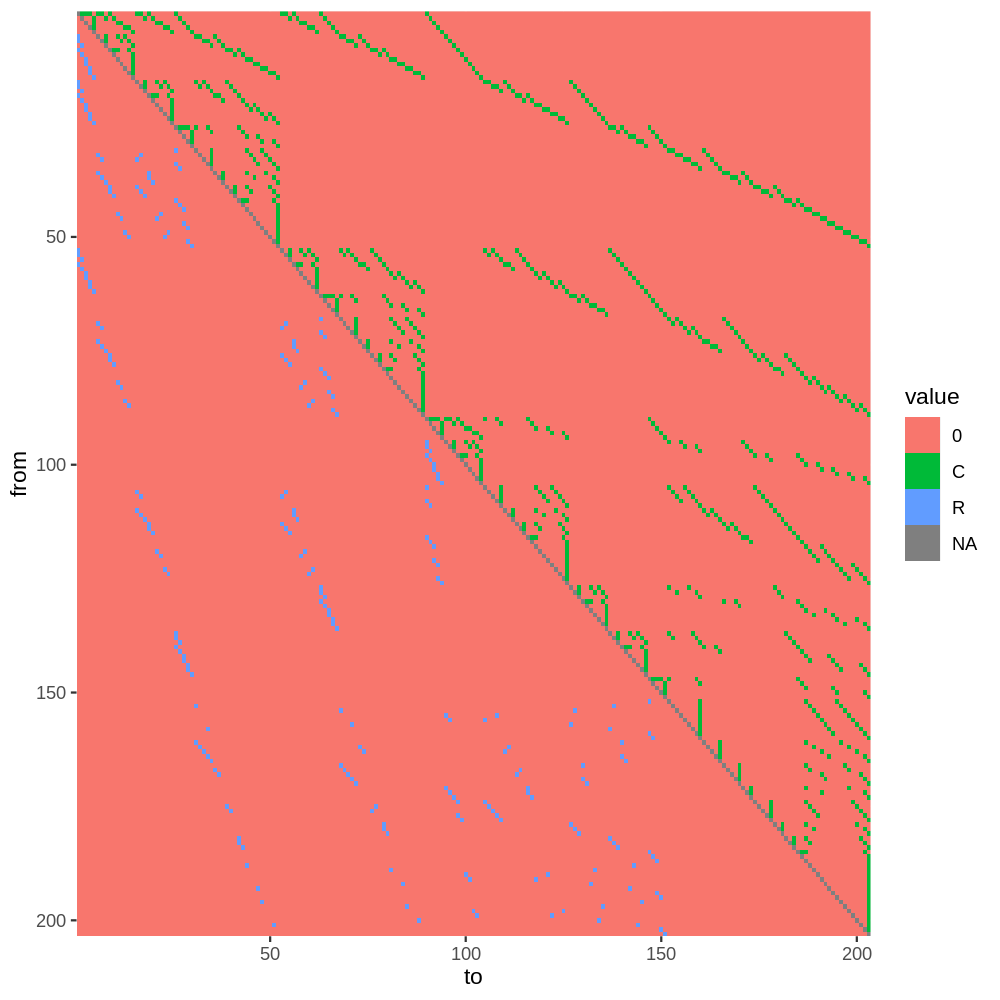

In [147]:
%%R -i trans_mat  -w 1000 -h 1000 -r 150

library(tidyverse)

as_tibble(trans_mat) %>% 
    mutate(from = 1:n()) %>% 
    pivot_longer(-from) %>% 
    mutate(to = as.integer(str_remove_all(name, 'V'))) %>% 
    select(from, to, value) %>% 
    mutate(value = ifelse(from==to, NA, value))  %>% 
    ggplot() +
    geom_tile(aes(to, from, fill = value)) +
    scale_y_reverse(expand = c(0, 0)) +
    scale_x_continuous(expand = c(0, 0))

In [127]:
trans_mat

array([['.', 'C', 'C', ..., '.', '.', '.'],
       ['.', '.', '.', ..., '.', '.', '.'],
       ['.', '.', '.', ..., '.', '.', '.'],
       ...,
       ['.', '.', '.', ..., '.', '.', 'C'],
       ['.', '.', '.', ..., '.', '.', 'C'],
       ['.', '.', '.', ..., '.', '.', '.']], dtype='<U1')